In [1]:
import pandas as pd
import sqlite3

In [3]:
db_file_path = 'catalogo_vagas.db'
table_name = 'vagas_de_emprego'


# Carregando os Dados
conn = sqlite3.connect(db_file_path)
query = f"SELECT * FROM {table_name}"
df = pd.read_sql_query(query, conn)
conn.close()


print(f"Dados carregados. Shape inicial: {df.shape}")

display(df.head())

df.info()

Dados carregados. Shape inicial: (2000, 51)


,id_vaga,nome_empresa,setor,cargo,habilidades_necessarias,nivel_experiencia,tipo_contratacao,localizacao,faixa_salarial_usd,data_postagem,...,pref_BigQuery,pref_TensorFlow,pref_PyTorch,pref_ScikitLearn,estado,salario_medio_setor,desvio_salarial_setor,idade_vaga_dias,salario_medio_segmento,popularidade_cargo_contrato
0,1,Foster and Sons,Saúde,Analista de Dados,"NumPy, Reinforcement Learning, PyTorch, Scikit...",Pleno,Tempo Integral,"Tracybury, AR",92860-109598,2025-08-20,...,0,0,0,0,AR,120964.24,-19735.24,45,122485.74,66
1,2,"Boyd, Myers and Ramirez",Tecnologia,Engenheiro de Visão Computacional,"Scikit-learn, CUDA, SQL, Pandas",Sênior,Tempo Integral,"Lake Scott, CU",78523-144875,2024-03-22,...,0,1,0,0,CU,123217.42,-11518.42,561,124828.81,60
2,3,King Inc,Tecnologia,Pesquisador Quantitativo,"MLflow, FastAPI, Azure, PyTorch, SQL, GCP",Júnior,Tempo Integral,"East Paige, CM",124496-217204,2025-09-18,...,1,0,1,1,CM,123217.42,47632.58,16,124828.81,63
3,4,"Cooper, Archer and Lynch",Tecnologia,Gerente de Produto de IA,"Scikit-learn, C++, Pandas, LangChain, AWS, R",Pleno,Tempo Integral,"Perezview, FI",50908-123743,2024-05-08,...,1,1,0,0,FI,123217.42,-35891.92,514,124828.81,68
4,5,Hall LLC,Finanças,Cientista de Dados,"Excel, Keras, SQL, Hugging Face",Sênior,Contrato,"North Desireeland, NE",98694-135413,2025-02-24,...,0,0,1,0,NE,123040.45,-5986.95,222,127051.92,64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 51 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id_vaga                      2000 non-null   int64  
 1   nome_empresa                 2000 non-null   object 
 2   setor                        2000 non-null   object 
 3   cargo                        2000 non-null   object 
 4   habilidades_necessarias      2000 non-null   object 
 5   nivel_experiencia            2000 non-null   object 
 6   tipo_contratacao             2000 non-null   object 
 7   localizacao                  2000 non-null   object 
 8   faixa_salarial_usd           2000 non-null   object 
 9   data_postagem                2000 non-null   object 
 10  tamanho_empresa              2000 non-null   object 
 11  ferramentas_preferenciais    2000 non-null   object 
 12  salario_min                  2000 non-null   float64
 13  salario_max       

## Etapa 1: Preparar o Terreno

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

y = df['nivel_experiencia']

colunas_para_encoder = ['setor', 'tipo_contratacao', 'tamanho_empresa'] 

df_encoded = pd.get_dummies(df, columns=colunas_para_encoder)

colunas_para_remover = [
    'id_vaga', 'nome_empresa', 'habilidades_necessarias',
    'localizacao', 'faixa_salarial_usd', 'data_postagem',
    'ferramentas_preferenciais', 'nivel_experiencia',
    'estado', 'cargo'
]

X = df_encoded.drop(columns=colunas_para_remover)

# Dividir os dados
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("--- TERRENO PREPARADO PARA A SINTONIA FINA ---")
print("Formato do X de treino:", X_train.shape)

--- TERRENO PREPARADO PARA A SINTONIA FINA ---
Formato do X de treino: (1600, 52)


## Etapa 2: Definir o "Grid de Busca"

In [61]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

## Etapa 3: Configurar e Executar a Busca

In [62]:
# Instanciando o modelo base
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Configurando o GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

print("\n--- INICIANDO A BUSCA... ISSO PODE DEMORAR ALGUNS MINUTOS. ---")
# Executando a busca
grid_search.fit(X_train, y_train)


--- INICIANDO A BUSCA... ISSO PODE DEMORAR ALGUNS MINUTOS. ---
Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'n_estimators': [100, 200]},
             verbose=2)

## Etapa 4: Analisar os Resultados

In [63]:
# Mostrando os melhores parâmetros encontrados
print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)

# Mostrando a melhor acurácia encontrada durante a busca
print("\nMelhor acurácia (validação cruzada):")
print(f"{grid_search.best_score_:.2%}")

Melhores parâmetros encontrados:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 200}

Melhor acurácia (validação cruzada):
36.62%


## O Mapa dos Erros (Matriz de Confusão)

A acurácia nos diz quantas vezes o modelo acertou, mas não onde ele errou. A Matriz de Confusão nos mostra isso. Ela cruza as classes Reais com as classes Previstas. Vamos ver se o modelo está confundindo "Pleno" com "Sênior", por exemplo.

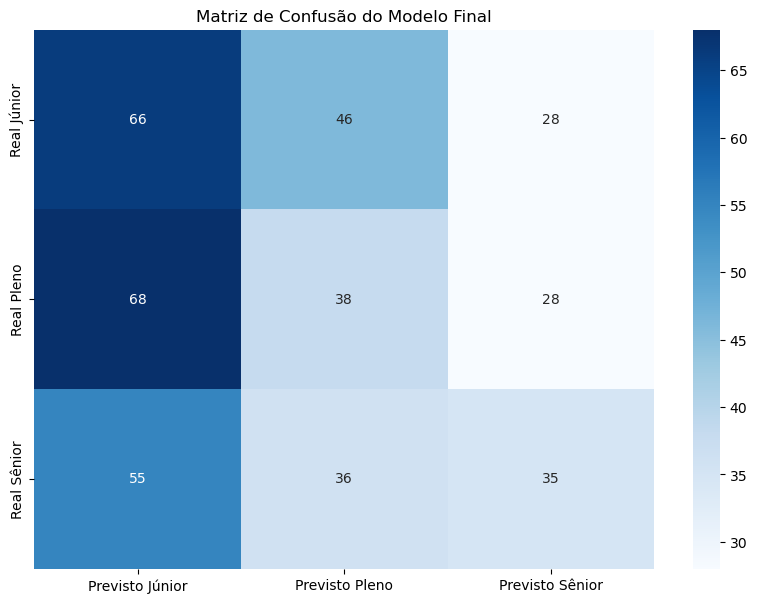

In [64]:
# --- ETAPA 1: MATRIZ DE CONFUSÃO ---
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Use o melhor modelo que o GridSearch encontrou para prever no X_test
best_model = grid_search.best_estimator_
y_pred_final = best_model.predict(X_test)

# Crie a matriz
cm = confusion_matrix(y_test, y_pred_final, labels=['Júnior', 'Pleno', 'Sênior'])
df_cm = pd.DataFrame(cm, index=['Real Júnior', 'Real Pleno', 'Real Sênior'], columns=['Previsto Júnior', 'Previsto Pleno', 'Previsto Sênior'])

# Plote o gráfico
plt.figure(figsize=(10,7))
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
plt.title('Matriz de Confusão do Modelo Final')
plt.show()


## Etapa 2: As Pistas Mais Importantes (Importância das Features)

Explicação: Mesmo com uma acurácia baixa, o Random Forest ainda elege algumas features como mais "importantes" que outras para tomar suas decisões. Vamos visualizar quais foram as 10 principais.

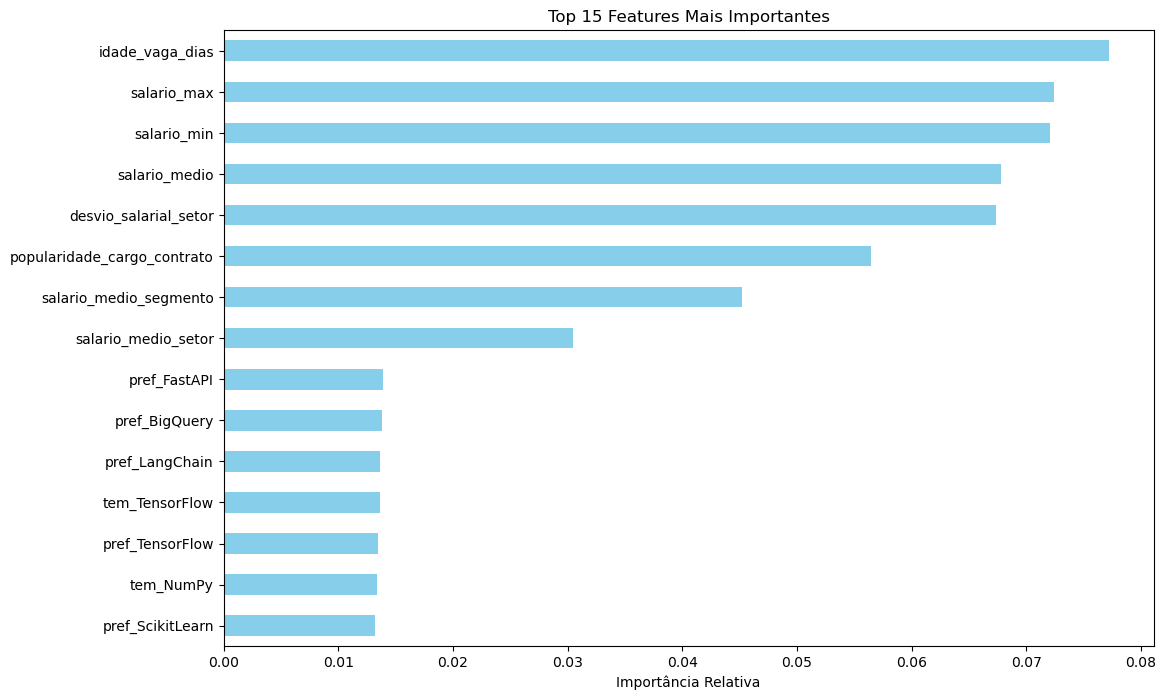

In [65]:
# --- ETAPA 2: IMPORTÂNCIA DAS FEATURES ---
# Pegando os nomes das features e a importância de cada uma
feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)

# Selecionando as 15 mais importantes e plotando
plt.figure(figsize=(12, 8))
feature_importances.nlargest(15).sort_values().plot(kind='barh', color='skyblue')
plt.title('Top 15 Features Mais Importantes')
plt.xlabel('Importância Relativa')
plt.show()